# Generating Mock Data

This notebook generates a realistic photometric survey catalog using a system of galaxy SED templates and photometric filters (included with the `frankenz` package). It is based on a [similar notebook](https://github.com/ixkael/Photoz-tools) written by Boris Leistedt ([@ixkael](http://github.com/ixkael)).

# Setup

Basic imports.

In [1]:
from __future__ import print_function, division
import sys
from sklearn.neighbors import KernelDensity
import dill
import numpy as np
import scipy
import matplotlib
from matplotlib import pyplot as plt
from six.moves import range

# import frankenz code
import frankenz

# plot in-line within the notebook
%matplotlib inline

np.random.seed(7)

Changing plotting defaults.

In [2]:
# re-defining plotting defaults
from matplotlib import rcParams
rcParams.update({'xtick.major.pad': '7.0'})
rcParams.update({'xtick.major.size': '7.5'})
rcParams.update({'xtick.major.width': '1.5'})
rcParams.update({'xtick.minor.pad': '7.0'})
rcParams.update({'xtick.minor.size': '3.5'})
rcParams.update({'xtick.minor.width': '1.0'})
rcParams.update({'ytick.major.pad': '7.0'})
rcParams.update({'ytick.major.size': '7.5'})
rcParams.update({'ytick.major.width': '1.5'})
rcParams.update({'ytick.minor.pad': '7.0'})
rcParams.update({'ytick.minor.size': '3.5'})
rcParams.update({'ytick.minor.width': '1.0'})
rcParams.update({'xtick.color': 'k'})
rcParams.update({'ytick.color': 'k'})
rcParams.update({'font.size': 30})

# Defining the Underlying Galaxy Population

Simulating an underlying galaxy population has a few main parts:
- a **prior** to characterize the underlying distribution of objects,
- a collection of **templates** used to model **spectral energy distributions (SEDs)** of our objects,
- a collection of **filters** through which the associated SEDS are observed, and
- a set of parameters associated with the observations (e.g., 5$\sigma$ magnitude limits). 

Most of the simulation utilities in `frankenz` are implemented via the `MockSurvey` class in `frankenz.simulate` allow users some amount of flexibility in terms of how these different pieces are implemented (such as incorporating custom sets of templates). It also includes a set of built-in options, which is what we'll be using here. See the documentation for additional details.

# Mock 1: SDSS

To start, we'll generate some data following the SDSS survey ($ugriz$ filters with SDSS depths) using the 8 `'cww+'` templates (based on those from [Coleman et al. 1980](http://adsabs.harvard.edu/abs/1980ApJS...43..393C)) and a joint redshift-type-magnitude $P(z,t,m)=P(m)P(t|m)P(z|t,m)$ prior, where $P(z|t,m)$ and $P(t|m)$ are from [BPZ](http://www.stsci.edu/~dcoe/BPZ/) ([Benitez 2000](http://adsabs.harvard.edu/abs/2000ApJ...536..571B)) and $P(m)$ is a truncated power law based on [Leistedt et al. (2016)](http://adsabs.harvard.edu/abs/2016MNRAS.460.4258L).

In [3]:
# construct our mock survey object
survey = frankenz.simulate.MockSurvey(survey='sdss', templates='cww+', prior='bpz')

Let's quickly plot some of these properties to get a sense of how things look.

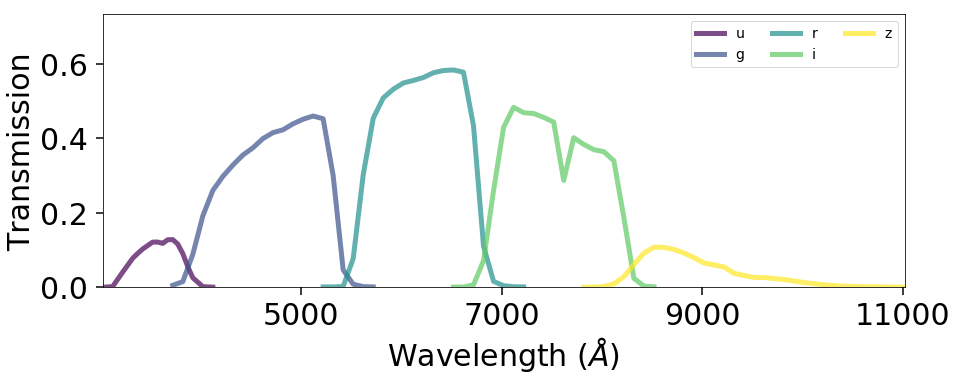

In [4]:
# plotting filters
fcolors = plt.get_cmap('viridis')(np.linspace(0, 1, survey.NFILTER))  # filter colors
xlow = min([min(f['wavelength']) for f in survey.filters])  # lower bound
xhigh = max([max(f['wavelength']) for f in survey.filters])  # upper bound
ylow, yhigh = 0., 0.

plt.figure(figsize=(14, 6))
for f, c in zip(survey.filters, fcolors):
    plt.plot(f['wavelength'], f['transmission'], lw=5, 
             color=c, alpha=0.7, label=f['name'])
    yhigh = max(yhigh, max(f['transmission']))
plt.xticks(np.arange(3000., 11000.+1., 2000.))
plt.xlim([xlow, xhigh])
plt.xlabel(r'Wavelength ($\AA$)')
plt.ylim([ylow, yhigh + 0.15])
plt.ylabel('Transmission')
plt.legend(loc='best', ncol=int(survey.NFILTER/2 + 1), fontsize=14)
plt.tight_layout()

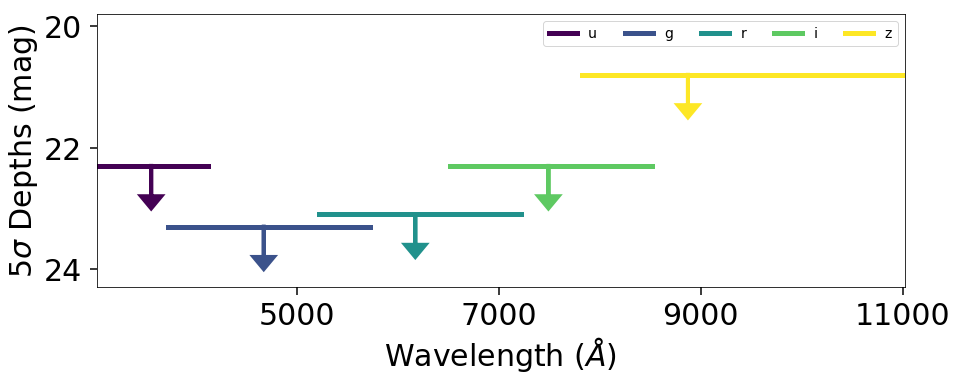

In [5]:
# plotting depths
depths = np.array([f['depth_mag5sig'] for f in survey.filters])

plt.figure(figsize=(14 ,6))
for f, c in zip(survey.filters, fcolors):
    plt.plot([min(f['wavelength']), max(f['wavelength'])], 
             [f['depth_mag5sig'], f['depth_mag5sig']],
             lw=5, color=c, label=f['name'])
    plt.arrow(f['lambda_eff'], f['depth_mag5sig'], 0.0, 0.5, lw=4,
              fc=c, ec=c, head_width=200, head_length=0.2)
plt.xticks(np.arange(3000., 11000.+1., 2000.))
plt.xlim([xlow, xhigh])
plt.xlabel(r'Wavelength ($\AA$)')
plt.ylim([max(depths) + 1.0, min(depths) - 1.0])
plt.ylabel(r'$5\sigma$ Depths (mag)')
plt.legend(ncol=survey.NFILTER, fontsize=14)
plt.tight_layout()

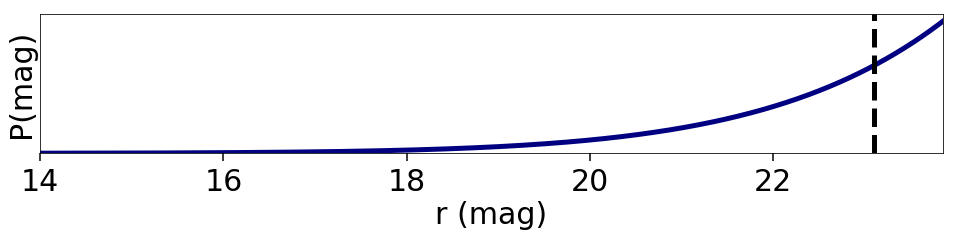

In [6]:
# plotting magnitude prior
plt.figure(figsize=(14, 4))
mdepth = depths[survey.ref_filter]
mhigh = mdepth + 2.5 * np.log10(2)
mgrid = np.arange(14., mhigh + 0.01, 0.01)
plt.plot(mgrid, survey.pm(mgrid, mdepth), lw=5, color='navy')
plt.axvline(mdepth, ls='--', lw=5, color='black')
plt.xlabel(survey.filters[survey.ref_filter]['name'] + ' (mag)')
plt.xlim([14., mhigh])
plt.ylabel('P(mag)')
plt.ylim([0., None])
plt.yticks([])
plt.tight_layout()

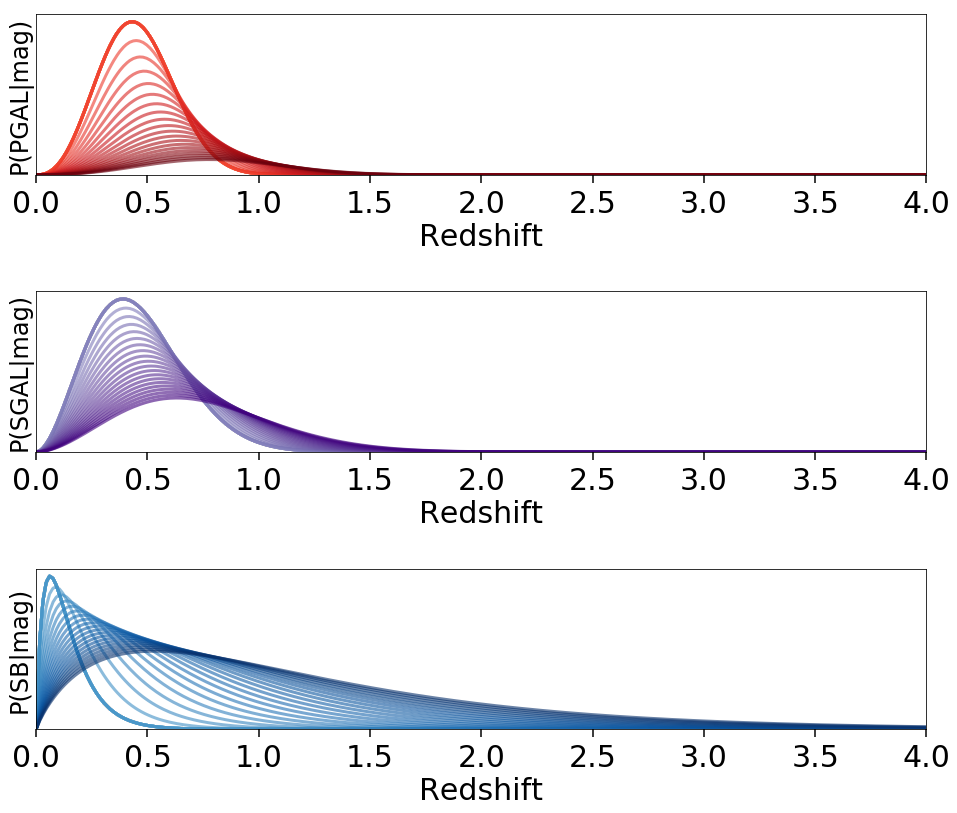

In [7]:
# plotting prior
mags = mgrid[::20]
Nmag = len(mags)
zgrid = np.linspace(0., 4., 1000)
pgal_colors = plt.get_cmap('Reds')(np.linspace(0, 1, Nmag))  # PGAL colors
sgal_colors = plt.get_cmap('Purples')(np.linspace(0, 1, Nmag))  # SGAL colors
sb_colors = plt.get_cmap('Blues')(np.linspace(0, 1, Nmag))  # SB colors

plt.figure(figsize=(14, 12))
for i, color in zip(range(survey.NTYPE), [pgal_colors, sgal_colors, sb_colors]):
    plt.subplot(3,1,i+1)
    for j, c in zip(mags, color):
        pztm = [survey.pztm(z, i, j) for z in zgrid]
        plt.plot(zgrid, pztm, lw=3, color=c, alpha=0.6)
    plt.xlabel('Redshift')
    plt.xlim([0, 4])
    plt.ylabel('P({0}|mag)'.format(survey.TYPES[i]), fontsize=24)
    plt.ylim([0., None])
    plt.yticks([])
    plt.tight_layout()

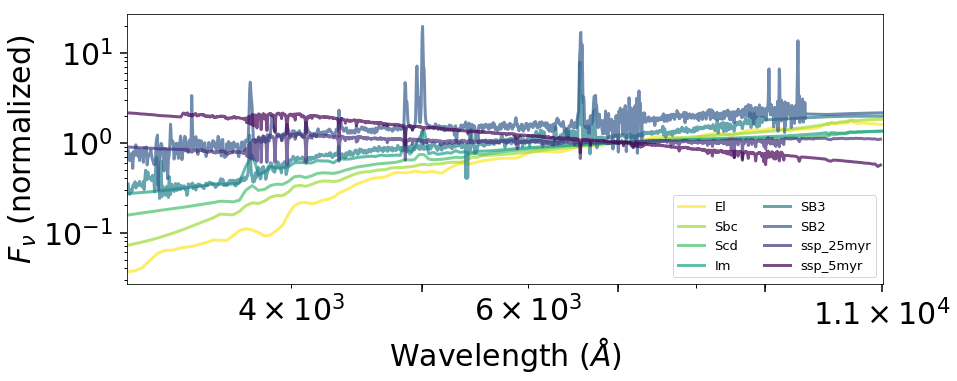

In [8]:
# plotting templates
tcolors = plt.get_cmap('viridis_r')(np.linspace(0., 1., survey.NTEMPLATE))  # template colors
plt.figure(figsize=(14, 6))
for t, c in zip(survey.templates, tcolors):
    wave, fnu, name = t['wavelength'], t['fnu'], t['name']
    sel = (wave > xlow) & (wave < xhigh)
    plt.loglog(wave[sel], fnu[sel], lw=3, color=c,
               label=name, alpha=0.7)
plt.xticks(np.arange(3000., 11000.+1., 2000.))
plt.xlim([xlow, xhigh])
plt.xlabel(r'Wavelength ($\AA$)')
plt.ylabel(r'$F_{\nu}$ (normalized)')
plt.legend(ncol=int(survey.NTEMPLATE/6 + 1), fontsize=13, loc=4)
plt.tight_layout()

# Sampling Galaxy Populations

Now that we've set up our priors, we can easily generate samples from the overall distribution.

In [9]:
# draw samples within the given magnitude and redshift bounds
Ndraws = 200000
mbounds, zbounds = [14., 25.], [0., 6.]
survey.sample_params(Ndraws, mbounds=mbounds, zbounds=zbounds)

Sampling mags: 200000/200000
Sampling types: 200000/200000
Sampling templates within each type: 3/3
Sampling redshifts: 200000/200000


Our results are stored within our `survey` under the `data` dictionary.

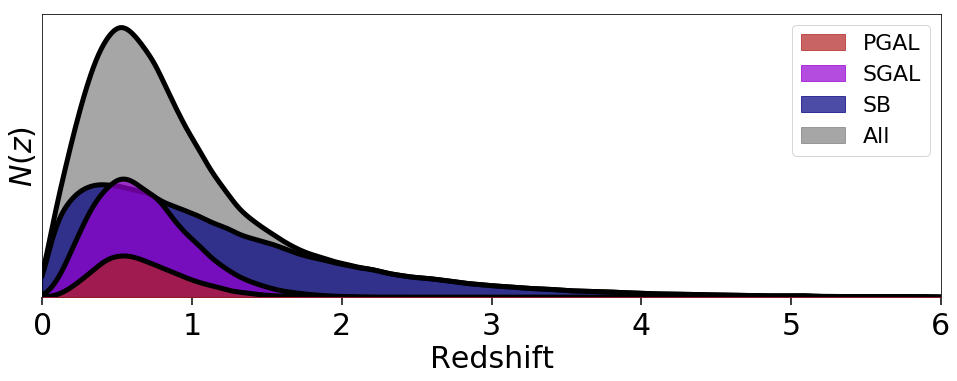

In [10]:
# plotting
plt.figure(figsize=(14, 6))
pcolors = ['firebrick', 'darkviolet', 'navy']  # prior colors
zgrid = np.linspace(zbounds[0], zbounds[1], 1000)
kde = KernelDensity(kernel='gaussian', bandwidth=0.05)  # initialize kde
for i in range(survey.NTYPE):
    # compute ln(KDE)
    kde.fit(survey.data['redshifts'][survey.data['types']==i][:, None])
    log_dens = kde.score_samples(zgrid[:, None])
    # plot result
    plt.plot(zgrid, np.exp(log_dens) * sum(survey.data['types']==i) / Ndraws,
             color='black', lw=5, zorder=survey.NTYPE-i)
    plt.fill_between(zgrid, np.exp(log_dens) * sum(survey.data['types']==i) / Ndraws, 
                     color=pcolors[i], alpha=0.7, label=survey.TYPES[i], 
                     zorder=survey.NTYPE-i)
# plot total KDE
kde.fit(survey.data['redshifts'][:, None])
log_dens = kde.score_samples(zgrid[:, None])
plt.plot(zgrid, np.exp(log_dens), color='black', lw=5, zorder=0)
plt.fill_between(zgrid, np.exp(log_dens), color='gray', alpha=0.7, 
                 label='All', zorder=0)
plt.legend(fontsize=22)
plt.xlabel('Redshift')
plt.xlim(zbounds)
plt.ylabel('$N(z)$')
plt.ylim([0., None])
plt.yticks([])
plt.tight_layout()

# Generating Mock Photometry

Now that we have a series of $P(t,z,m)$ draws, we have to convert those into actual fluxes. This involves picking a template (at random) within each sampled type $t$ (which is already done in `sample_params`), redshifting our underlying templates by the sampled redshift $z$, integrating over the relevant filters, and then jittering the fluxes by the appropriate background errors according to the sampled magnitude $m$. While this necessarily ignores Poisson noise, it's a reasonable approximation in the background-dominated regime where most objects are observed. The impact of intra-galactic extinction is modeled using an old parameterization by Madau et al. (1999).

We can do this using the `sample_phot` function.

In [11]:
# sample photometry
survey.sample_phot()

Generating photometry: 200000/200000
Sampling errors: 200000/200000
Sampling photometry: 200000/200000


If we'd rather do both of these steps at once, we can use the `make_mock` function (which just wraps `sample_params` and `sample_phot`).

We can visualize our models below using our templates evaluated over a given redshift grid. These are evaluated and stored internally (under `models`) using the `make_model_grid` function.

In [12]:
# evaluate templates over a given redshift grid
survey.make_model_grid(zgrid)

Generating model photometry grid: 1000/1000

/home/joshspeagle/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in true_divide
/home/joshspeagle/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: divide by zero encountered in log10


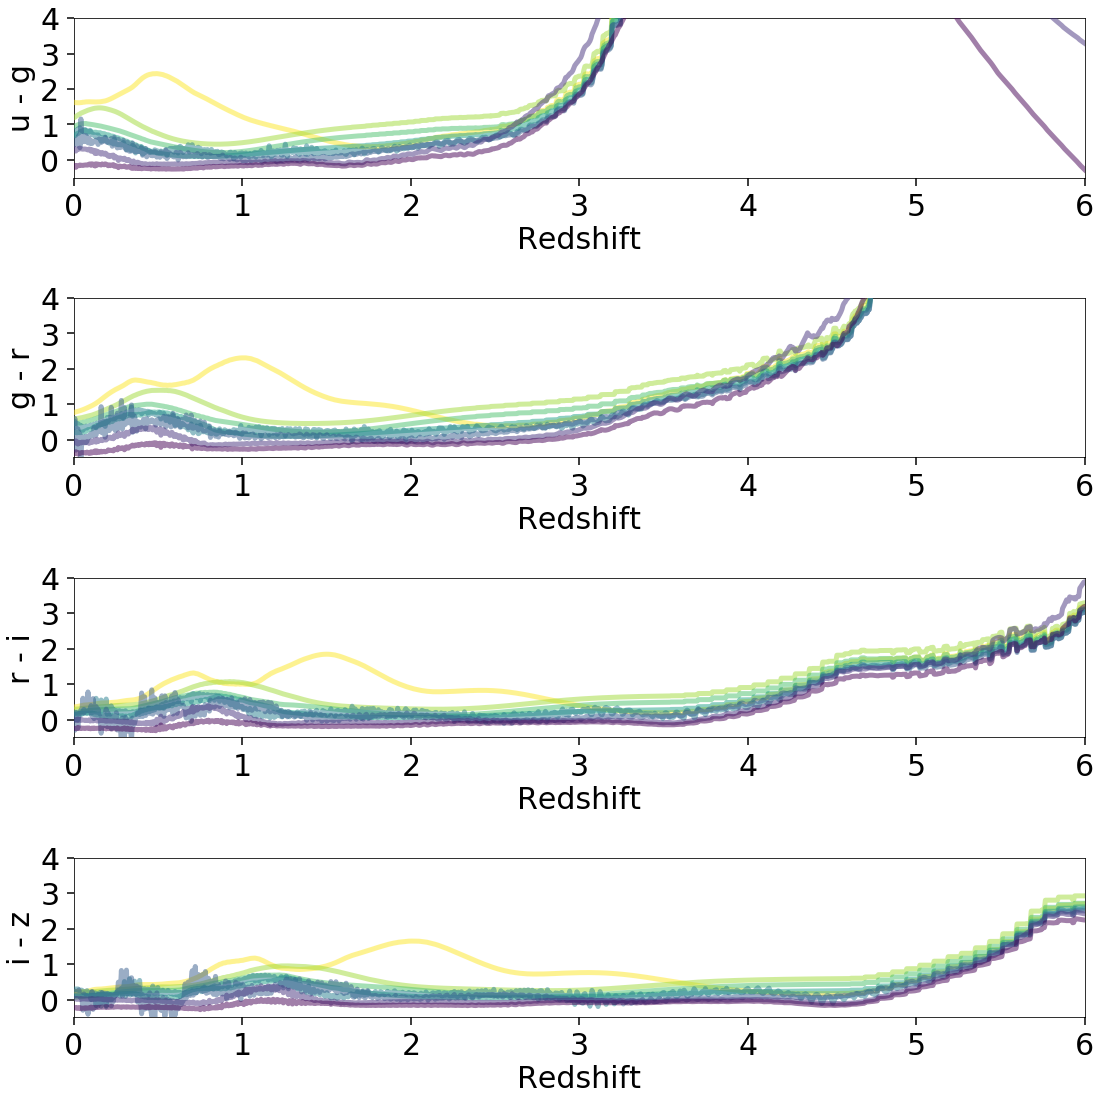

In [13]:
# plotting color-redshift tracts
plt.figure(figsize=(16, 4 * (survey.NFILTER - 1)))
for i in range(survey.NFILTER-1):
    plt.subplot(survey.NFILTER - 1, 1, i + 1)
    for j in range(survey.NTEMPLATE):
        mcolors = -2.5 * np.log10(survey.models['data'][:, j, i] / 
                                  survey.models['data'][:, j, i+1])
        plt.plot(zgrid, mcolors, color=tcolors[j], lw=5, alpha=0.5, zorder=3)
    plt.xticks(np.linspace(0, 6, 7))
    plt.xlabel('Redshift')
    plt.xlim(zbounds)
    plt.yticks(np.linspace(-1, 4, 6))
    plt.ylim([-0.5, 4])
    plt.ylabel(survey.filters[i]['name'] + ' - ' + survey.filters[i+1]['name'])
    plt.tight_layout()

/home/joshspeagle/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in true_divide
/home/joshspeagle/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: divide by zero encountered in log10
/home/joshspeagle/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log10


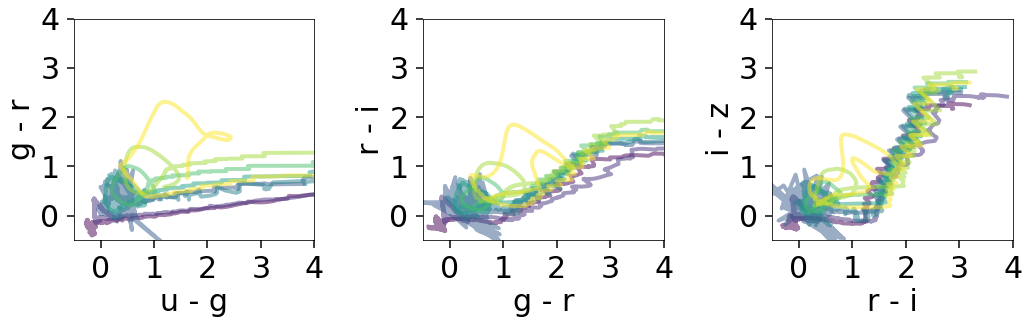

In [14]:
# plotting color-color distributions
plt.figure(figsize=(5 * (survey.NFILTER - 2), 5.2))
for i in xrange(survey.NFILTER-2):
    plt.subplot(1, survey.NFILTER-2, i+1)
    for j in np.arange(survey.NTEMPLATE)[::-1]:
        mc1 = -2.5 * np.log10(survey.models['data'][:, j, i] / 
                              survey.models['data'][:, j, i+1])
        mc2 = -2.5 * np.log10(survey.models['data'][:, j, i+1] / 
                              survey.models['data'][:, j, i+2])
        plt.plot(mc1, mc2, color=tcolors[j], lw=4, alpha=0.5, zorder=1)
    plt.xticks(np.linspace(-2,4,7))
    plt.xlim([-0.5, 4])
    plt.xlabel(survey.filters[i]['name'] + ' - ' + survey.filters[i+1]['name'])
    plt.yticks(np.linspace(-2,4,7))
    plt.ylim([-0.5, 4])
    plt.ylabel(survey.filters[i+1]['name'] + ' - ' + survey.filters[i+2]['name'])
    plt.tight_layout()

Note that the model grid we generated to visualize these template-redshift tracts will be utilized in the next notebook.

## Wrapping up

We're now done, so let's dump our survey to disk.

In [15]:
dill.dump(survey, open('../data/mock_sdss_cww_bpz.pkl', 'wb'))

# Mock 2: HSC Data

In addition to SDSS, we will also construct a mock catalog based on the 5-band $grizy$ [HSC SSP](http://hsc.mtk.nao.ac.jp/ssp/) survey using the 129 `'brown'` templates from [Brown et al. (2014)](http://adsabs.harvard.edu/abs/2014ApJS..212...18B).

In [16]:
survey = frankenz.simulate.MockSurvey(survey='hsc', templates='brown', prior='bpz')

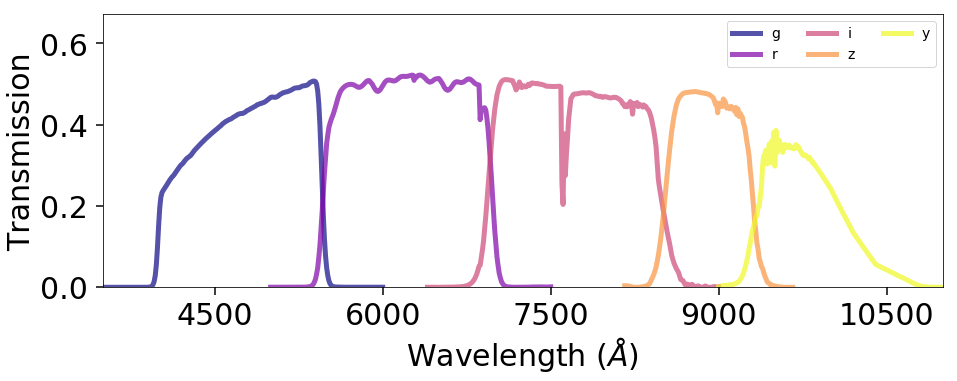

In [17]:
# plotting filters
fcolors = plt.get_cmap('plasma')(np.linspace(0, 1, survey.NFILTER))  # filter colors
xlow = min([min(f['wavelength']) for f in survey.filters])  # lower bound
xhigh = max([max(f['wavelength']) for f in survey.filters])  # upper bound
ylow, yhigh = 0., 0.

plt.figure(figsize=(14, 6))
for f, c in zip(survey.filters, fcolors):
    plt.plot(f['wavelength'], f['transmission'], lw=5, 
             color=c, alpha=0.7, label=f['name'])
    yhigh = max(yhigh, max(f['transmission']))
plt.xticks(np.arange(3000., 11000.+1., 1500.))
plt.xlim([xlow, xhigh])
plt.xlabel(r'Wavelength ($\AA$)')
plt.ylim([ylow, yhigh + 0.15])
plt.ylabel('Transmission')
plt.legend(loc='best', ncol=int(survey.NFILTER/2 + 1), fontsize=14)
plt.tight_layout()

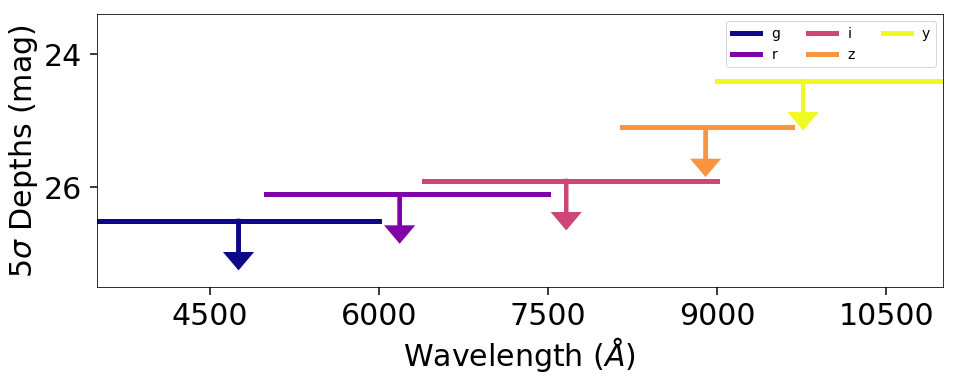

In [18]:
# plotting depths
depths = np.array([f['depth_mag5sig'] for f in survey.filters])

plt.figure(figsize=(14 ,6))
for f, c in zip(survey.filters, fcolors):
    plt.plot([min(f['wavelength']), max(f['wavelength'])], [f['depth_mag5sig'], f['depth_mag5sig']],
             lw=5, color=c, label=f['name'])
    plt.arrow(f['lambda_eff'], f['depth_mag5sig'], 0.0, 0.5, lw=4,
              fc=c, ec=c, head_width=200, head_length=0.2)
plt.xticks(np.arange(3000., 11000.+1., 1500.))
plt.xlim([xlow, xhigh])
plt.xlabel(r'Wavelength ($\AA$)')
plt.ylim([max(depths) + 1.0, min(depths) - 1.0])
plt.ylabel(r'$5\sigma$ Depths (mag)')
plt.legend(loc='best', ncol=int(survey.NFILTER/2 + 1), fontsize=14)
plt.tight_layout()

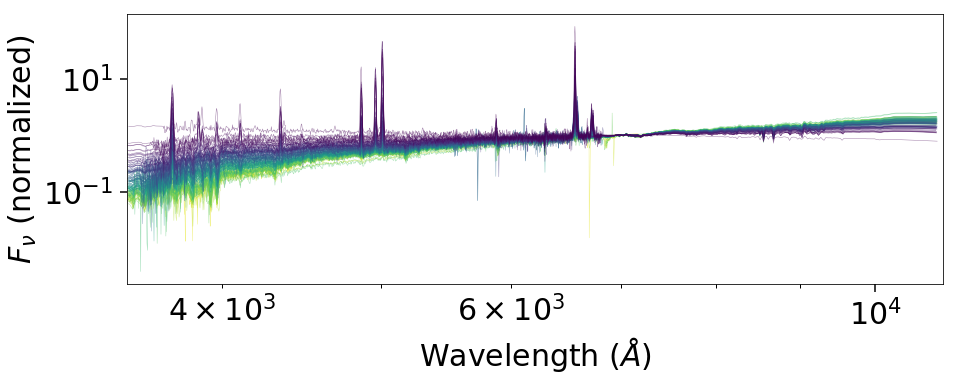

In [19]:
# plotting templates
tcolors = plt.get_cmap('viridis_r')(np.linspace(0., 1., survey.NTEMPLATE))  # template colors
plt.figure(figsize=(14, 6))
for t, c in zip(survey.templates, tcolors):
    wave, fnu, name = t['wavelength'], t['fnu'], t['name']
    sel = (wave > xlow) & (wave < xhigh)
    plt.loglog(wave[sel], fnu[sel], lw=0.5, color=c,
               label=name, alpha=0.5)
plt.xlim([xlow, xhigh])
plt.xlabel(r'Wavelength ($\AA$)')
plt.ylabel(r'$F_{\nu}$ (normalized)')
plt.tight_layout()

In [20]:
Ndraws = 200000
mbounds, zbounds = [14., 27.5], [0., 8.]
survey.make_mock(Ndraws, mbounds=mbounds, zbounds=zbounds)

Sampling mags: 200000/200000
Sampling types: 200000/200000
Sampling templates within each type: 3/3
Sampling redshifts: 200000/200000
Generating photometry: 200000/200000
Sampling errors: 200000/200000
Sampling photometry: 200000/200000


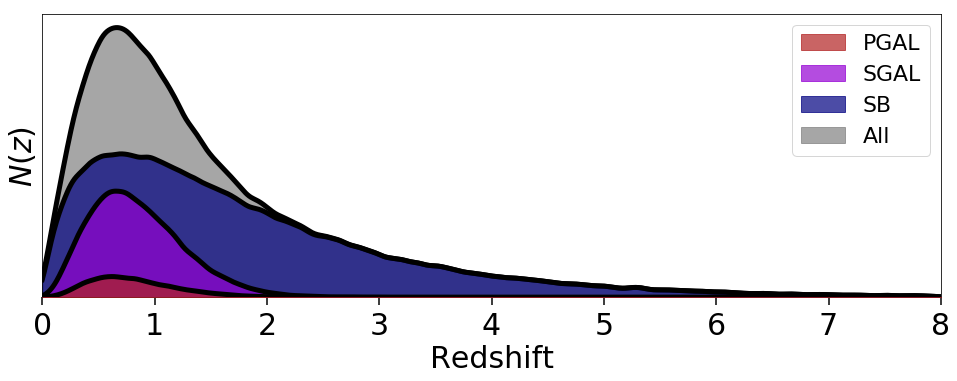

In [21]:
# plotting
plt.figure(figsize=(14, 6))
zgrid = np.linspace(zbounds[0], zbounds[1], 1000)
kde = KernelDensity(kernel='gaussian', bandwidth=0.05)  # initialize kde
for i in range(survey.NTYPE):
    # compute ln(KDE)
    kde.fit(survey.data['redshifts'][survey.data['types']==i][:, None])
    log_dens = kde.score_samples(zgrid[:, None])
    # plot result
    plt.plot(zgrid, np.exp(log_dens) * sum(survey.data['types']==i) / Ndraws,
             color='black', lw=5, zorder=survey.NTYPE-i)
    plt.fill_between(zgrid, np.exp(log_dens) * sum(survey.data['types']==i) / Ndraws, 
                     color=pcolors[i], alpha=0.7, label=survey.TYPES[i], 
                     zorder=survey.NTYPE-i)
# plot total KDE
kde.fit(survey.data['redshifts'][:, None])
log_dens = kde.score_samples(zgrid[:, None])
plt.plot(zgrid, np.exp(log_dens), color='black', lw=5, zorder=0)
plt.fill_between(zgrid, np.exp(log_dens), color='gray', alpha=0.7, 
                 label='All', zorder=0)
plt.legend(fontsize=22)
plt.xlabel('Redshift')
plt.xlim(zbounds)
plt.ylabel('$N(z)$')
plt.ylim([0., None])
plt.yticks([])
plt.tight_layout()

In [22]:
# evaluate templates over a given redshift grid
survey.make_model_grid(zgrid)

Generating model photometry grid: 1000/1000

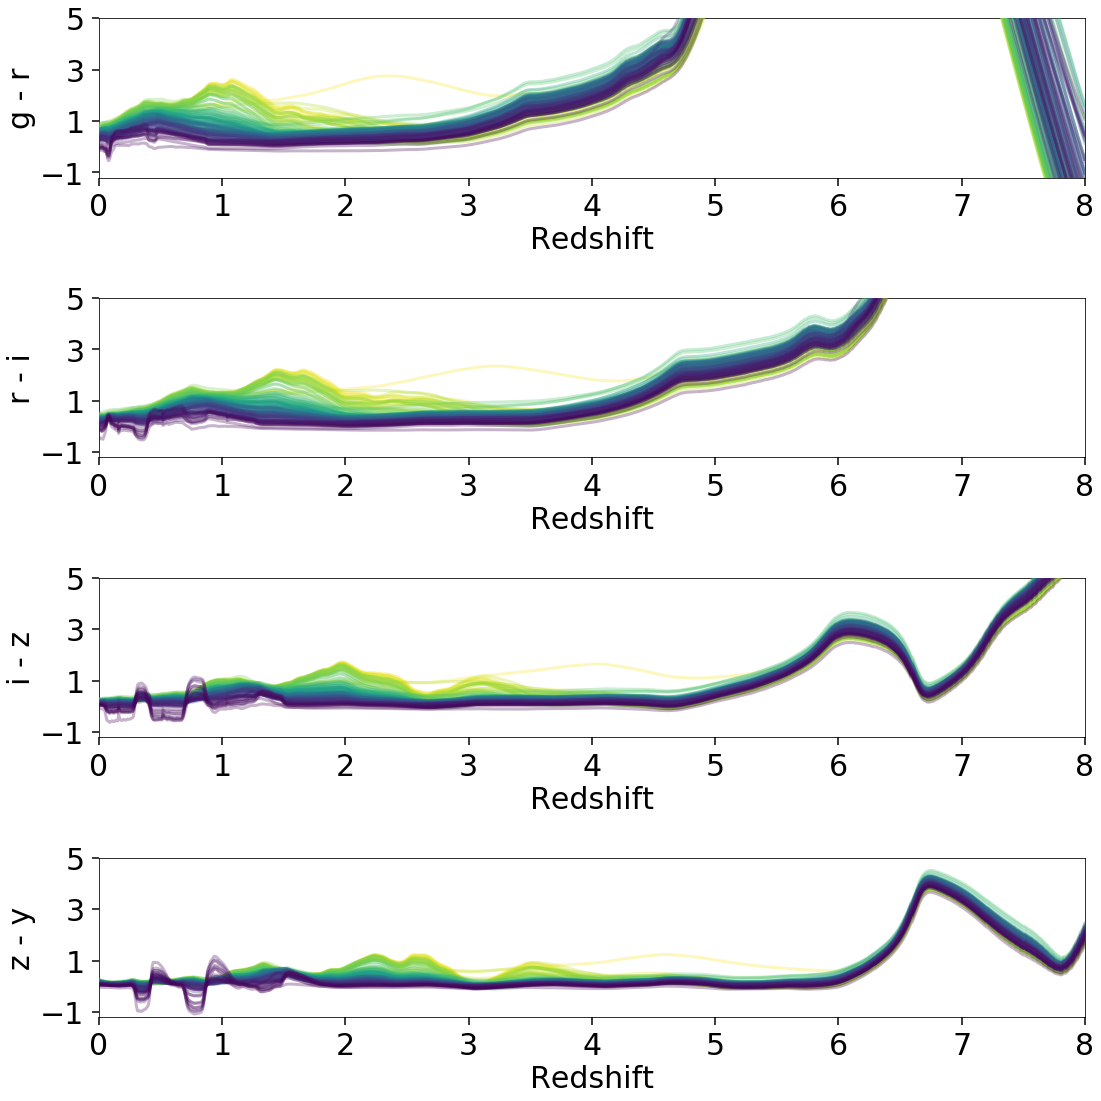

In [23]:
# plotting color-redshift tracts
plt.figure(figsize=(16, 4 * (survey.NFILTER - 1)))
for i in range(survey.NFILTER-1):
    plt.subplot(survey.NFILTER - 1, 1, i + 1)
    for j in range(survey.NTEMPLATE):
        mcolors = -2.5 * np.log10(survey.models['data'][:, j, i] / 
                                  survey.models['data'][:, j, i+1])
        plt.plot(zgrid, mcolors, color=tcolors[j], lw=3, alpha=0.3, zorder=3)
    plt.xticks(np.linspace(0, 8, 9))
    plt.xlabel('Redshift')
    plt.xlim(zbounds)
    plt.yticks(np.linspace(-1, 5, 4))
    plt.ylim([-1.2, 5])
    plt.ylabel(survey.filters[i]['name'] + ' - ' + survey.filters[i+1]['name'])
    plt.tight_layout()

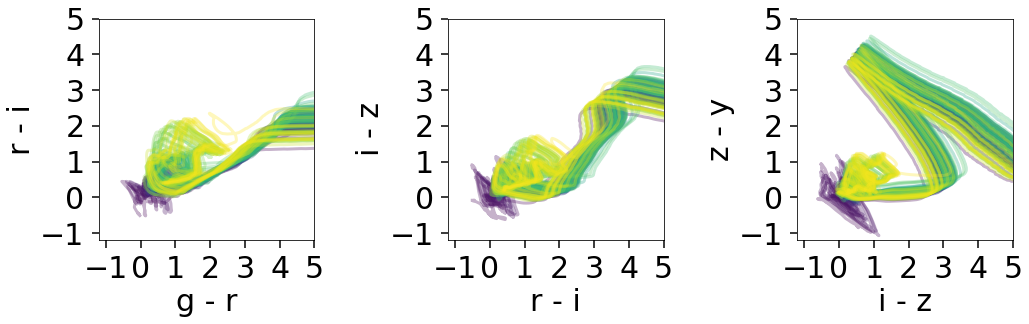

In [24]:
# plotting color-color distributions
plt.figure(figsize=(5 * (survey.NFILTER - 2), 5.2))
for i in xrange(survey.NFILTER-2):
    plt.subplot(1, survey.NFILTER-2, i+1)
    for j in np.arange(survey.NTEMPLATE)[::-1]:
        mc1 = -2.5 * np.log10(survey.models['data'][:, j, i] / survey.models['data'][:, j, i+1])
        mc2 = -2.5 * np.log10(survey.models['data'][:, j, i+1] / survey.models['data'][:, j, i+2])
        plt.plot(mc1, mc2, color=tcolors[j], lw=3, alpha=0.3, zorder=1)
    plt.xticks(np.linspace(-2,5,8))
    plt.xlim([-1.2, 5])
    plt.xlabel(survey.filters[i]['name'] + ' - ' + survey.filters[i+1]['name'])
    plt.yticks(np.linspace(-2,5,8))
    plt.ylim([-1.2, 5])
    plt.ylabel(survey.filters[i+1]['name'] + ' - ' + survey.filters[i+2]['name'])
    plt.tight_layout()

In [25]:
dill.dump(survey, open('../data/mock_hsc_brown_bpz.pkl', 'wb'))

# Mock 3: COSMOS Data

We will also construct a mock catalog based on the 30-band [COSMOS](http://cosmos.astro.caltech.edu/) survey using the 31 templates from [Polletta et al. (2007)](http://adsabs.harvard.edu/abs/2007ApJ...663...81P) and [Ilbert et al. (2009)](http://adsabs.harvard.edu/abs/2009ApJ...690.1236I).

In [26]:
survey = frankenz.simulate.MockSurvey(survey='cosmos', templates='polletta+', prior='bpz')

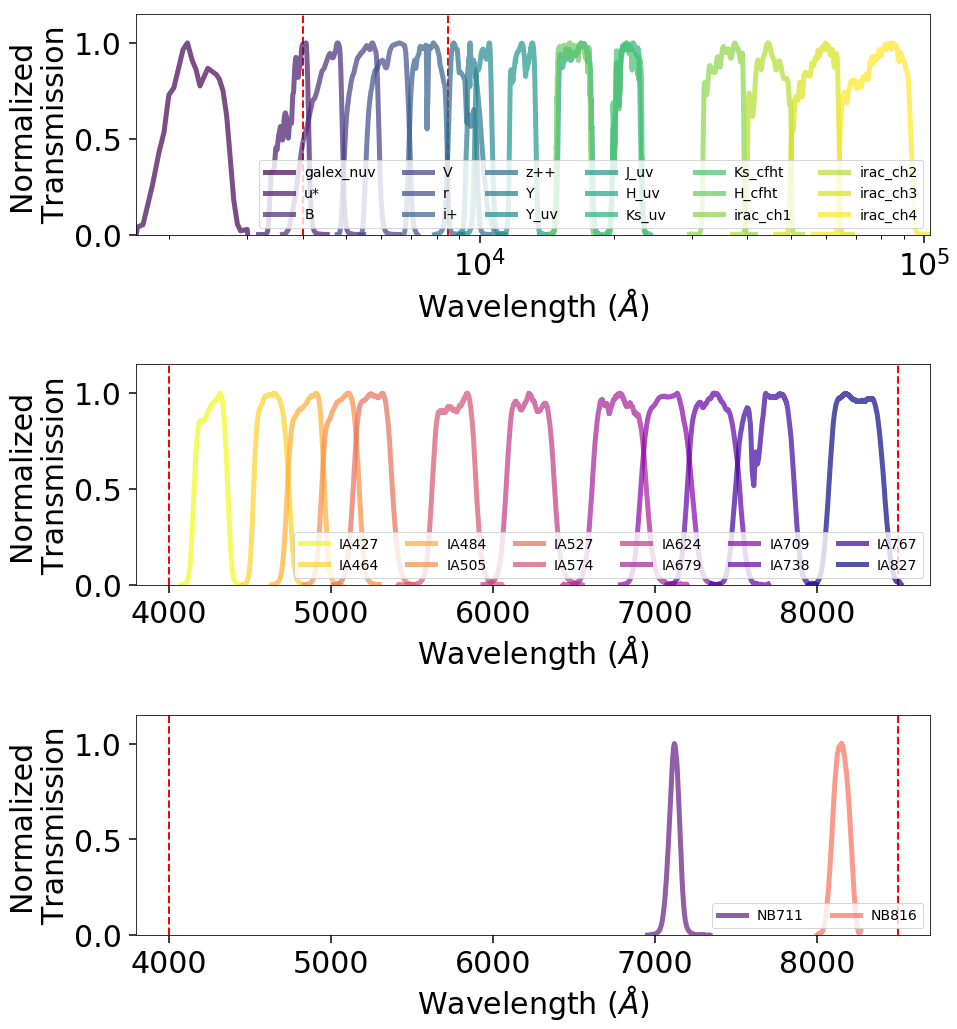

In [27]:
# plotting filters
xlow = min([min(f['wavelength']) for f in survey.filters])  # lower bound
xhigh = max([max(f['wavelength']) for f in survey.filters])  # upper bound
ylow, yhigh = 0., 0.
plt.figure(figsize=(14, 15))

# plot broadband filters
plt.subplot(3, 1, 1)
bbsel = np.append(np.arange(0, 7), np.arange(21, survey.NFILTER))  # broad-bands
fcolors = plt.get_cmap('viridis')(np.linspace(0, 1, len(bbsel)))
for i, c in zip(bbsel, fcolors):
    f = survey.filters[i]
    plt.semilogx(f['wavelength'], f['transmission'] / max(f['transmission']),
                 lw=5, color=c, alpha=0.7, label=f['name'])
    yhigh = max(yhigh, max(f['transmission']))
plt.vlines([4000., 8500.], 1.2, 0., linestyles='--', colors='red', linewidths=2)
plt.xlim([xlow, xhigh])
plt.xlabel(r'Wavelength ($\AA$)')
plt.ylim([ylow, yhigh + 0.15])
plt.ylabel('Normalized\nTransmission')
plt.legend(loc=4, ncol=int(survey.NFILTER/6 + 1), fontsize=14)
plt.tight_layout()

# plot intermediate-band filters
plt.subplot(3, 1, 2)
iasel = np.arange(7, 19)  # intermediate-bands
fcolors = plt.get_cmap('plasma_r')(np.linspace(0, 1, len(iasel)))
for i, c in zip(iasel, fcolors):
    f = survey.filters[i]
    plt.plot(f['wavelength'], f['transmission'] / max(f['transmission']),
                 lw=5, color=c, alpha=0.7, label=f['name'])
    yhigh = max(yhigh, max(f['transmission']))
plt.vlines([4000., 8500.], 1.2, 0., linestyles='--', colors='red', linewidths=2)
plt.xlabel(r'Wavelength ($\AA$)')
plt.xlim([3800., 8700.])
plt.ylim([ylow, yhigh + 0.15])
plt.ylabel('Normalized\nTransmission')
plt.legend(loc=4, ncol=int(survey.NFILTER/6 + 1), fontsize=14)
plt.tight_layout()

# plot intermediate-band filters
plt.subplot(3, 1, 3)
nbsel = np.arange(19, 21)  # narrow-bands
fcolors = plt.get_cmap('magma')(np.linspace(0.3, 0.7, len(nbsel)))
for i, c in zip(nbsel, fcolors):
    f = survey.filters[i]
    plt.plot(f['wavelength'], f['transmission'] / max(f['transmission']),
                 lw=5, color=c, alpha=0.7, label=f['name'])
    yhigh = max(yhigh, max(f['transmission']))
plt.vlines([4000., 8500.], 1.2, 0., linestyles='--', colors='red', linewidths=2)
plt.xlabel(r'Wavelength ($\AA$)')
plt.xlim([3800., 8700.])
plt.ylim([ylow, yhigh + 0.15])
plt.ylabel('Normalized\nTransmission')
plt.legend(loc=4, ncol=2, fontsize=14)
plt.tight_layout()

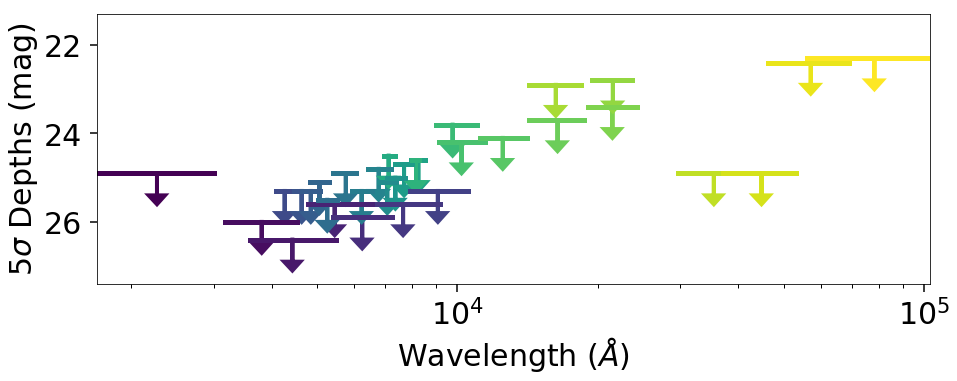

In [28]:
# plotting depths
depths = np.array([f['depth_mag5sig'] for f in survey.filters])
fcolors = plt.get_cmap('viridis')(np.linspace(0, 1, survey.NFILTER))
plt.figure(figsize=(14 ,6))
for f, c in zip(survey.filters, fcolors):
    plt.semilogx([min(f['wavelength']), max(f['wavelength'])], 
                 [f['depth_mag5sig'], f['depth_mag5sig']],
                 lw=5, color=c, label=f['name'])
    plt.arrow(f['lambda_eff'], f['depth_mag5sig'], 0.0, 0.5, lw=4,
              fc=c, ec=c, head_width=0.08*f['lambda_eff'], head_length=0.2)
plt.xlim([xlow, xhigh])
plt.xlabel(r'Wavelength ($\AA$)')
plt.ylim([max(depths) + 1.0, min(depths) - 1.0])
plt.ylabel(r'$5\sigma$ Depths (mag)')
plt.tight_layout()

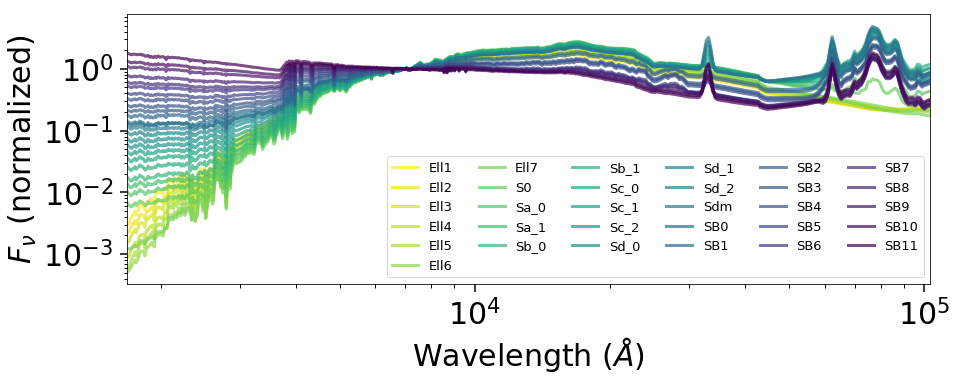

In [29]:
# plotting templates
tcolors = plt.get_cmap('viridis_r')(np.linspace(0., 1., survey.NTEMPLATE))  # template colors
plt.figure(figsize=(14, 6))
for t, c in zip(survey.templates, tcolors):
    wave, fnu, name = t['wavelength'], t['fnu'], t['name']
    sel = (wave > xlow) & (wave < xhigh)
    plt.loglog(wave[sel], fnu[sel], lw=3, color=c,
                 label=name, alpha=0.7)
plt.xlim([xlow, xhigh])
plt.xlabel(r'Wavelength ($\AA$)')
plt.ylabel(r'$F_{\nu}$ (normalized)')
plt.legend(ncol=int(survey.NTEMPLATE/6 + 1), fontsize=13, loc=4)
plt.tight_layout()

In [30]:
Ndraws = 200000
mbounds, zbounds = [14., 27.5], [0., 8.]
survey.make_mock(Ndraws, mbounds=mbounds, zbounds=zbounds)

Sampling mags: 200000/200000
Sampling types: 200000/200000
Sampling templates within each type: 3/3
Sampling redshifts: 200000/200000
Generating photometry: 200000/200000
Sampling errors: 200000/200000
Sampling photometry: 200000/200000


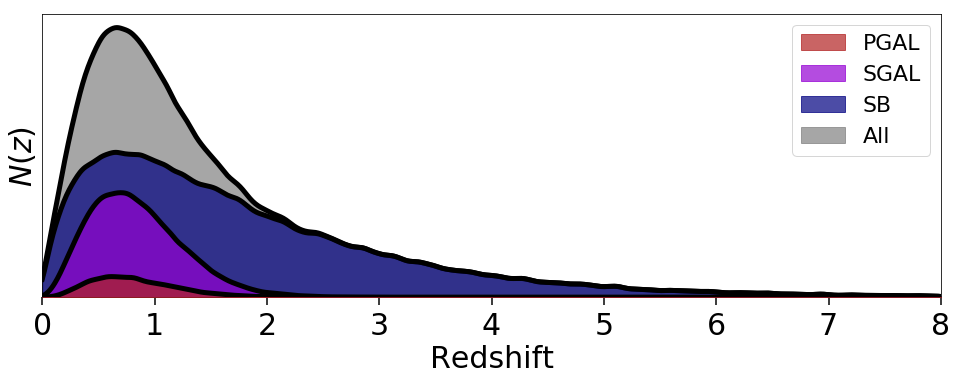

In [31]:
# plotting
plt.figure(figsize=(14, 6))
zgrid = np.linspace(zbounds[0], zbounds[1], 1000)
kde = KernelDensity(kernel='gaussian', bandwidth=0.05)  # initialize kde
for i in range(survey.NTYPE):
    # compute ln(KDE)
    kde.fit(survey.data['redshifts'][survey.data['types']==i][:, None])
    log_dens = kde.score_samples(zgrid[:, None])
    # plot result
    plt.plot(zgrid, np.exp(log_dens) * sum(survey.data['types']==i) / Ndraws,
             color='black', lw=5, zorder=survey.NTYPE-i)
    plt.fill_between(zgrid, np.exp(log_dens) * sum(survey.data['types']==i) / Ndraws, 
                     color=pcolors[i], alpha=0.7, label=survey.TYPES[i], 
                     zorder=survey.NTYPE-i)
# plot total KDE
kde.fit(survey.data['redshifts'][:, None])
log_dens = kde.score_samples(zgrid[:, None])
plt.plot(zgrid, np.exp(log_dens), color='black', lw=5, zorder=0)
plt.fill_between(zgrid, np.exp(log_dens), color='gray', alpha=0.7, 
                 label='All', zorder=0)
plt.legend(fontsize=22)
plt.xlabel('Redshift')
plt.xlim(zbounds)
plt.ylabel('$N(z)$')
plt.ylim([0., None])
plt.yticks([])
plt.tight_layout()

In [32]:
# evaluate templates over a given redshift grid
survey.make_model_grid(zgrid)

Generating model photometry grid: 1000/1000

/home/joshspeagle/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in true_divide
/home/joshspeagle/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: divide by zero encountered in log10


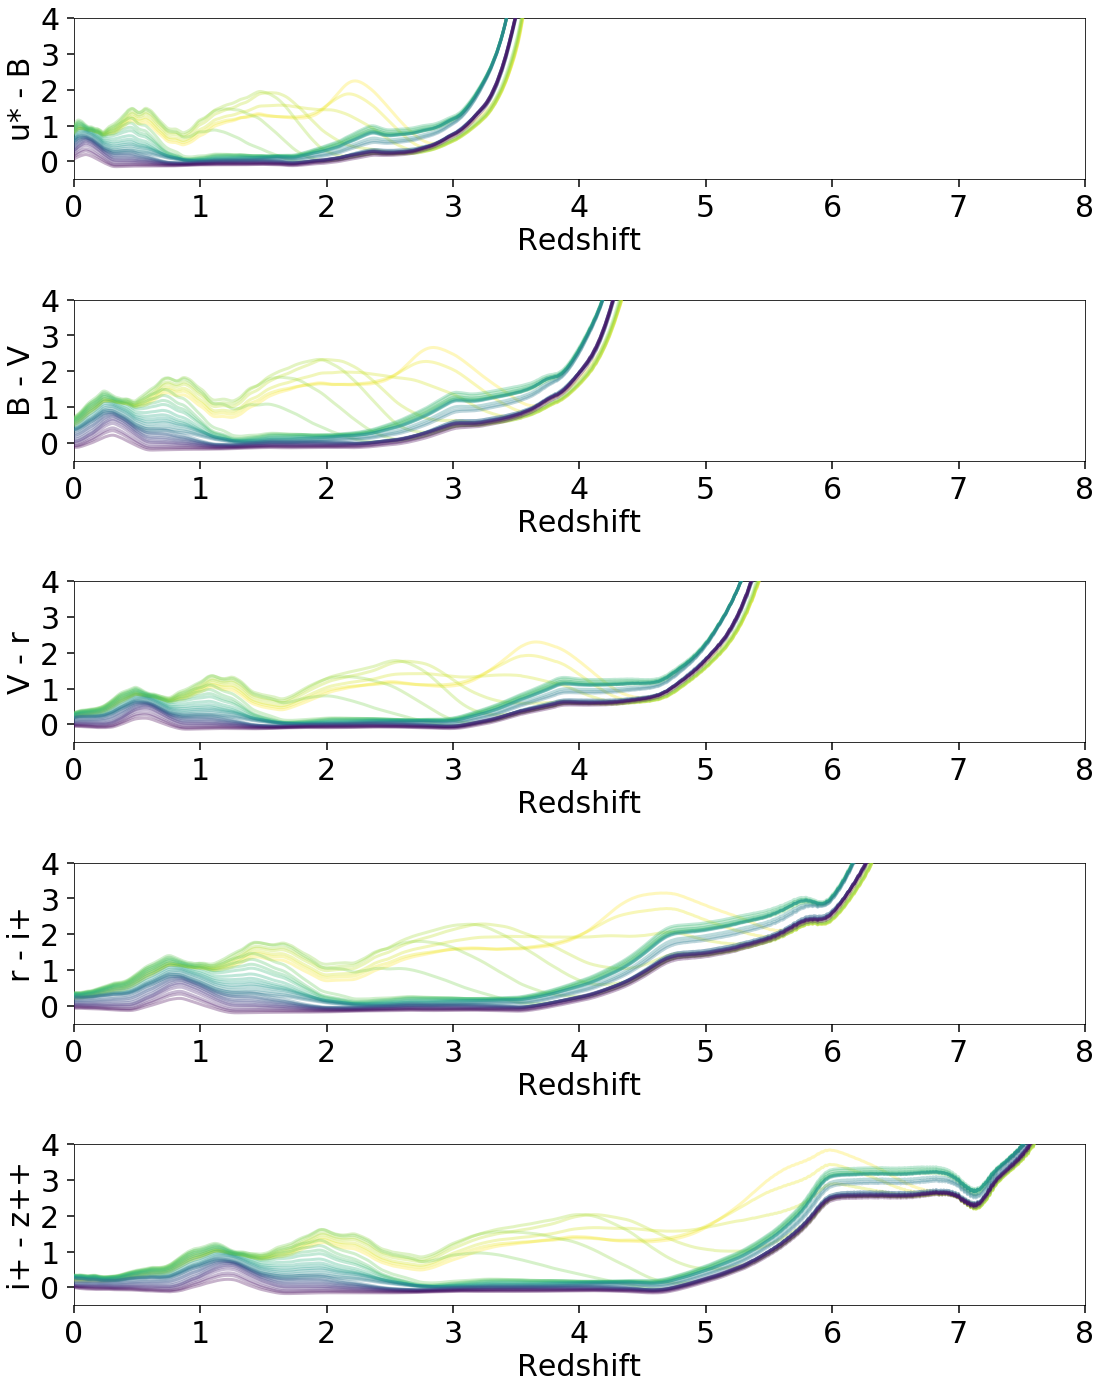

In [33]:
# plotting color-redshift tracts
plt.figure(figsize=(16, 4 * 5))
for i in range(5):
    plt.subplot(5, 1, i + 1)
    for j in range(survey.NTEMPLATE):
        mcolors = -2.5 * np.log10(survey.models['data'][:, j, i+1] / 
                                  survey.models['data'][:, j, i+2])
        plt.plot(zgrid, mcolors, color=tcolors[j], lw=3, alpha=0.3, zorder=3)
    plt.xticks(np.linspace(0, 8, 9))
    plt.xlabel('Redshift')
    plt.xlim(zbounds)
    plt.yticks(np.linspace(-1, 4, 6))
    plt.ylim([-0.5, 4])
    plt.ylabel(survey.filters[i+1]['name'] + ' - ' + survey.filters[i+2]['name'])
    plt.tight_layout()

/home/joshspeagle/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in true_divide
/home/joshspeagle/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: divide by zero encountered in log10
/home/joshspeagle/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in true_divide
/home/joshspeagle/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: divide by zero encountered in log10


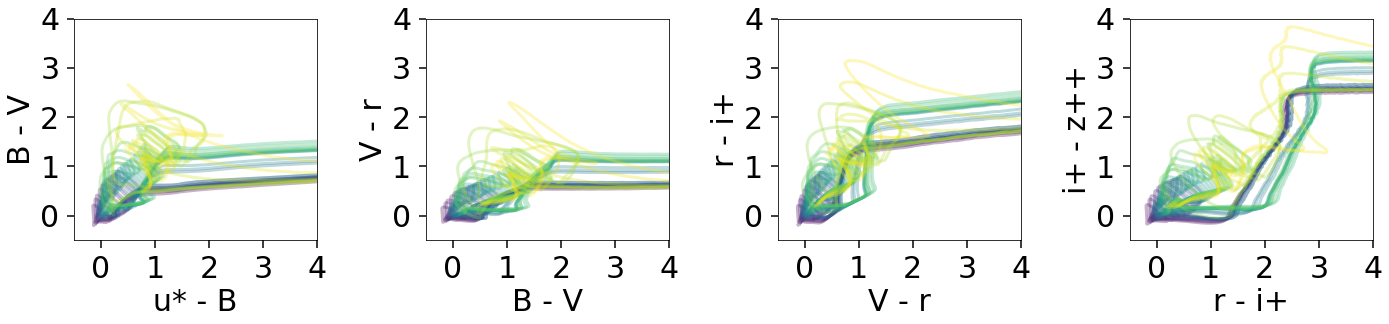

In [34]:
# plotting color-color distributions
plt.figure(figsize=(5 * 4, 5.2))
for i in xrange(4):
    plt.subplot(1, 4, i+1)
    for j in np.arange(survey.NTEMPLATE)[::-1]:
        mc1 = -2.5 * np.log10(survey.models['data'][:, j, i+1] / survey.models['data'][:, j, i+2])
        mc2 = -2.5 * np.log10(survey.models['data'][:, j, i+2] / survey.models['data'][:, j, i+3])
        plt.plot(mc1, mc2, color=tcolors[j], lw=3, alpha=0.3, zorder=1)
    plt.xticks(np.linspace(-2,4,7))
    plt.xlim([-0.5, 4])
    plt.xlabel(survey.filters[i+1]['name'] + ' - ' + survey.filters[i+2]['name'])
    plt.yticks(np.linspace(-2,4,7))
    plt.ylim([-0.5, 4])
    plt.ylabel(survey.filters[i+2]['name'] + ' - ' + survey.filters[i+3]['name'])
    plt.tight_layout()

In [35]:
dill.dump(survey, open('../data/mock_cosmos_polletta_bpz.pkl', 'wb'))